# DT logs prediction model research

## Contents

* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Model training](#Model-training)
* [Inference](#Inference)
* [Metrics evaluation](#Metrics-evaluation)
* [Conclusion](#Conclusion)

## Problem description

Predict DT logs values based on other logs values and depth info.

In [1]:
%env CUDA_VISIBLE_DEVICES=0

import os
import sys

import torch
import pickle
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.insert(0, "/notebooks/goryachev/petroflow")

from petroflow import WellDataset, WS
from petroflow.batchflow import Pipeline, B, V, C
from petroflow.batchflow.research import Research
from petroflow.batchflow.models.torch import TorchModel
from petroflow.models.logs_prediction.utils import build_dataset, calc_metrics, batch_mse, moving_average_1d

env: CUDA_VISIBLE_DEVICES=0


## Dataset

A dataset of 608 wells with filtered data.

In [2]:
FILTERED_DATASET_PATH = "../data/filtered/*"
filtered_dataset = WellDataset(path=FILTERED_DATASET_PATH, dirs=True)

DT values are predicted by GK, NKTD and GZ1 logs and depth info.

In [3]:
INPUTS_COL = ['GK', 'NKTD', 'GZ1', "DEPTH KM"]
TARGET_COL = ['DT']
PROPER_COL = INPUTS_COL + TARGET_COL

8 crops of length 6.4m will be sampled from each well in a batch.

In [4]:
N_CROPS = 8
CROP_SIZE = 64
REINDEXATION_STEP = 0.1
CROP_LENGTH = CROP_SIZE * REINDEXATION_STEP

Split logs by non nan segments.

In [5]:
split_pipeline = filtered_dataset >> Pipeline().drop_nans()
batch = split_pipeline.next_batch(filtered_dataset.size)
dataset = build_dataset(batch)
dataset.split(shuffle=11)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



## Model architecture

Linear regression is used for prediction:

* Model consists of one dense layer.

* Adam optimizer with default parameters is used for model training. 

* Mean-squared error is used as a loss function.

Model configuration specification:

In [6]:
INPUTS_SIZE = len(INPUTS_COL)
TARGET_SIZE = len(TARGET_COL)

model_config = {
    'initial_block/inputs': 'inputs',
    'inputs/inputs': {'shape': [INPUTS_SIZE, CROP_SIZE]},
    'inputs/target': {'shape': [CROP_SIZE]},
    'loss': 'mse',
    'optimizer': 'Adam',
    'body/units': CROP_SIZE,
    'body/layout': 'f',
    'device' : C('device')
}

## Research

Here train and test pipelines are run simultaneously to detect optimal train pipeline stop iteration.

In [7]:
res_name = 'optimal_stop'
def clear_previous_results(res_name):
    if os.path.exists(res_name):
        shutil.rmtree(res_name)

In [12]:
BATCH_SIZE = 32

train_template = (Pipeline()
    .add_namespace(np)
    .random_crop(CROP_LENGTH, N_CROPS)
    .update(B('inputs'), WS('logs')[INPUTS_COL].values.ravel())
    .stack(B("inputs"), save_to=B("inputs"))
    .swapaxes(B("inputs"), 1, 2, save_to=B("inputs"))
    .array(B("inputs"), dtype=np.float32, save_to=B("inputs"))
    .update(B('target'), WS('logs')[TARGET_COL].values.ravel())
    .stack(B("target"), save_to=B("target"))
    .squeeze(B("target"), save_to=B("target"))
    .array(B("target"), dtype=np.float32, save_to=B("target"))
    .init_variable('train_loss')
    .init_model('dynamic', TorchModel, 'linear', model_config)
    .train_model('linear', B('inputs'), B('target'), fetches='loss', save_to=V('train_loss', mode='w'))
    .run_later(batch_size=BATCH_SIZE, shuffle=True, drop_last=True, n_epochs=None)
)

train_pipeline = dataset.train >> train_template

In [13]:
test_template = (Pipeline()
    .add_namespace(np)
    .crop(CROP_LENGTH, CROP_LENGTH)
    .update(B('inputs'), WS('logs')[INPUTS_COL].values.ravel())
    .stack(B("inputs"), save_to=B("inputs"))
    .swapaxes(B("inputs"), 1, 2, save_to=B("inputs"))
    .array(B("inputs"), dtype=np.float32, save_to=B("inputs"))
    .update(B('target'), WS('logs')[TARGET_COL].values.ravel())
    .stack(B("target"), save_to=B("target"))
    .squeeze(B("target"), save_to=B("target"))
    .array(B("target"), dtype=np.float32, save_to=B("target"))
    .init_variable('prediction')
    .import_model('linear', train_pipeline)
    .predict_model('linear', B('inputs'), fetches='predictions', save_to=B('prediction'))
    .init_variable('test_loss')
    .batch_mse(B("target"), B("prediction"), save_to=V('test_loss', mode='w'))
    .run_later(batch_size=dataset.test.size, shuffle=False, drop_last=False, n_epochs=1)
)

test_pipeline = dataset.test >> test_template

In [15]:
TEST_EXECUTE_FREQ = ['#0', 10]

ITERATIONS = 500

clear_previous_results(res_name)

research = (Research()
            .add_pipeline(train_pipeline, variables='train_loss', name='train_pipeline')
            .add_pipeline(test_pipeline, variables='test_loss', name='test_pipeline',
                          import_from='train_pipeline', run=True, execute=TEST_EXECUTE_FREQ))

research.run(n_iters=ITERATIONS, name=res_name, devices=[0], bar=True)

Research optimal_stop is starting...


Domain updated: 0:   2%|▏         | 9/500.0 [03:40<3:20:45, 24.53s/it]  /usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

Domain updated: 0:   4%|▍         | 19/500.0 [07:02<2:58:19, 22.24s/it]/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

Domain updated: 0:   6%|▌         | 29/500.0 [10:13<2:46:10, 21.17s/it]/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/

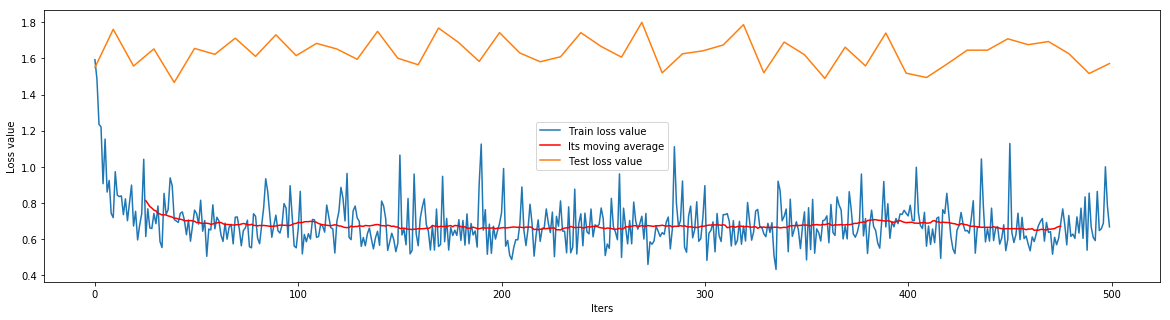

In [24]:
df = research.load_results()
train_loss = df[df['name'] == 'train_pipeline'][['iteration', 'train_loss']].values.T
test_loss = df[df['name'] == 'test_pipeline'][['iteration', 'test_loss']].values.T

fig = plt.figure(figsize=(20, 5))
plt.plot(*train_loss)
plt.plot(moving_average_1d(train_loss[1], 50), 'r')
plt.plot(*test_loss)
plt.xlabel("Iters")
plt.ylabel("Loss value")
plt.legend(["Train loss value", "Its moving average", "Test loss value"])
plt.show()

After 100 epochs train loss reaches the plateau at ~0.7.

Test loss starts from ~1.6 and stochastically oscillates around this value for the rest of the training period.

## Inference

Inference pipeline is similar to the test one, but all predictions are stored in a pipeline now.

In [17]:
inference_template = (Pipeline()
    .add_namespace(np)
    .crop(CROP_LENGTH, CROP_LENGTH)
    .update(B('inputs'), WS('logs')[INPUTS_COL].values.ravel())
    .stack(B("inputs"), save_to=B("inputs"))
    .swapaxes(B("inputs"), 1, 2, save_to=B("inputs"))
    .array(B("inputs"), dtype=np.float32, save_to=B("inputs"))
    .update(B('target'), WS('logs')[TARGET_COL].values.ravel())
    .stack(B("target"), save_to=B("target"))
    .squeeze(B("target"), save_to=B("target"))
    .array(B("target"), dtype=np.float32, save_to=B("target"))
    .init_variable('targets', default=[])
    .update(V('targets', mode='a'), B('target'))
    .init_variable('predictions', default=[])
    .import_model('linear', train_pipeline)
    .update_config({'device': torch.device('cuda:0')})
    .predict_model('linear', B('inputs'), fetches='predictions', save_to=V('predictions', mode='a'))
)

## Metrics evaluation

Two metrics used for model evaluation:
* Mean squared error (MSE)
* proportion of variance explained by model to data variance (R^2)

In [21]:
inference_pipeline = dataset.test >> inference_template
inference_pipeline.run(batch_size=1, n_iters=1, shuffle=True, drop_last=False)

true = np.concatenate([target.flatten() for target in inference_pipeline.v('targets')])
pred = np.concatenate([prediction.flatten() for prediction in inference_pipeline.v('predictions')])

metrics = calc_metrics(true, pred)

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



MSE: 1.803
R^2: -0.811


Plot several randomly chosen predictions.

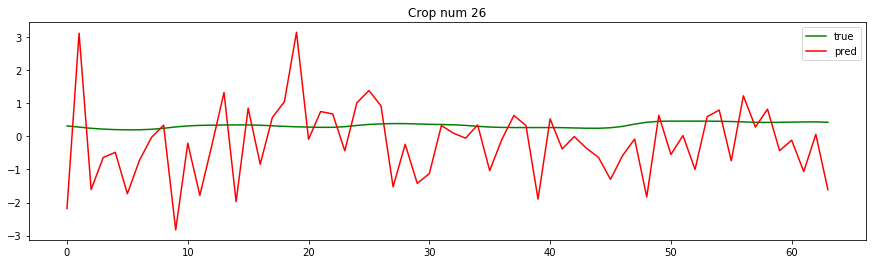

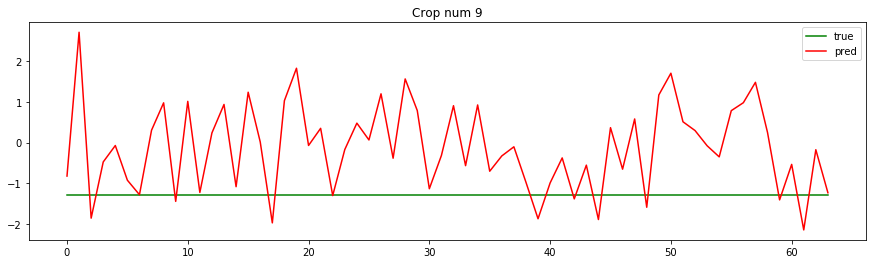

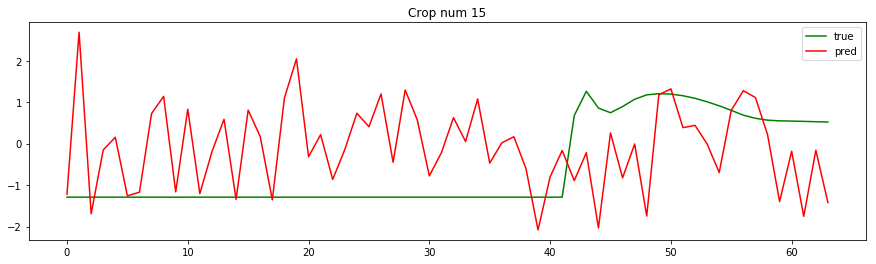

In [19]:
BATCH_NUM = np.random.randint(len(inference_pipeline.v('predictions')))
GRAPH_NUM = inference_pipeline.v('predictions')[BATCH_NUM].shape[0]
PRINT_NUM = 3
for crop_num in np.random.choice(GRAPH_NUM, PRINT_NUM, replace=False):
    true = inference_pipeline.v('targets')[BATCH_NUM][crop_num,:]
    pred = inference_pipeline.v('predictions')[BATCH_NUM][crop_num,:]

    fig = plt.figure(figsize=(15, 4))
    plt.title("Crop num {}".format(crop_num))
    plt.plot(true, 'g')
    plt.plot(pred, 'r')
    plt.legend(['true', 'pred'])
    plt.show()

## Conclusion

There is no need in accurate early stopping detection, since linear model is not capable of overfitting on given data due to its low generalization capability.

All we can do here, is basically train model until target function becomes less "saw-like" and more "smooth".